# Using K-Means Clustering on the Titanic Dataset

In [1]:
import pandas as pd
titanic = pd.read_csv('/Datasets/Titanic/train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Data Cleaning and Feature Engineering**

In [2]:
# Remove PassengerID, Name, Ticket and Cabin as these features are not as useful
titanic = titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

In [3]:
# Fill in missing values: Age (median) and Embarked (mode)
titanic['Age'].fillna((titanic['Age'].median()), inplace=True)
mode = titanic['Embarked'].value_counts().index[0]
titanic.loc[pd.isnull(titanic['Embarked']), 'Embarked'] = mode

In [4]:
# Cast categorical features to categorical
titanic['Survived'] = pd.Categorical(titanic.Survived)
titanic['Pclass'] = pd.Categorical(titanic.Pclass)
titanic['Embarked'] = pd.Categorical(titanic.Embarked)
titanic['Sex'] = pd.Categorical(titanic.Sex)

In [5]:
# Engineer a new feature for family size
titanic['FamilySize'] = 1 + titanic['SibSp'] + titanic['Parch']

import numpy as np
# Engineer a new feature to track which Age values are missing
titanic['AgeMissing'] = titanic['Age'].copy() 
titanic['AgeMissing'].fillna(0, inplace = True)
titanic['AgeMissing'] = np.where(titanic['AgeMissing']==0, 'Y', 'N')

In [6]:
# Define the subset of features that we will use.
features = ["Pclass", "Sex", "Age",
              "SibSp", "Parch", "Fare", "Embarked",
              "FamilySize", "AgeMissing"]

In [7]:
# Use pandas to convert factors to dummy variables.
titanic = pd.get_dummies(data=titanic, columns=features)

**Build Model**

The "elbow" method is used to determine the optimal number of clusters.

In [8]:
# Establish a vector to hold all values.
titanic = pd.DataFrame(data=titanic)

In [9]:
from sklearn.cluster import KMeans
# Build the model
titanic_km_model = KMeans(n_clusters=10, max_iter=300, n_init=10,
                      init='k-means++', tol=.0001)

# Train the model
titanic_km_model = titanic_km_model.fit(titanic)

**Build Scree Plot**

Text(0, 0.5, 'Cluster Sum of Squared Distances')

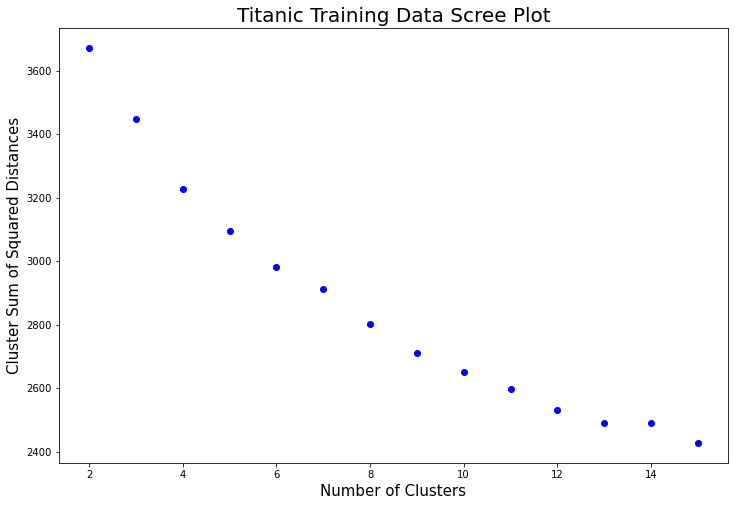

In [10]:
import matplotlib.pyplot as plt

# Calculate sum of squared distances of samples to their closest cluster center
titanic_skree_inertia = []
clusters = range(2,16)
for n_cluster in clusters:
    titanic_model = KMeans(n_clusters=n_cluster, max_iter=300, n_init=10,
                      init='k-means++', tol=.0001).fit(titanic.iloc[:,1:])
    titanic_skree_inertia.append(titanic_model.inertia_)

# Plot scree plot
plt.figure(figsize=(12,8))
plt.plot(clusters,titanic_skree_inertia, 'bo')
plt.title("Titanic Training Data Scree Plot", fontsize=20)
plt.xlabel("Number of Clusters", fontsize=15)
plt.ylabel("Cluster Sum of Squared Distances", fontsize=15)

**Visualize Survivability by Cluster**

In [11]:
# Cluster the data using the value from the elbow method.
titanic_km_model = KMeans(n_clusters=6, max_iter=300, n_init=10,
                      init='k-means++', tol=.0001)

In [12]:
# Add cluster assignments to the data frame
titanic_km_model = titanic_km_model.fit(titanic)
titanic['cluster'] = titanic_km_model.labels_

Text(0, 0.5, 'Passenger Count')

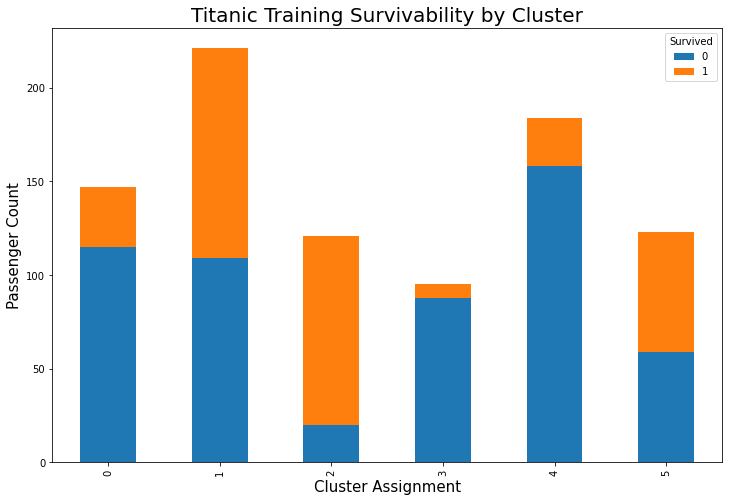

In [13]:
# Visualize survivability by cluster assignment.
titanic_2 = titanic.groupby(['Survived', 'cluster'])['cluster'].count().unstack('Survived').fillna(0)
ax = titanic_2[[0,1]].plot(kind='bar', stacked=True, figsize=(12,8))
ax.set_title("Titanic Training Survivability by Cluster", fontsize=20)
ax.set_xlabel("Cluster Assignment", fontsize=15)
ax.set_ylabel("Passenger Count", fontsize=15)

**Build and Visualize Tree Model**

In [14]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1).fit(titanic.drop('cluster', axis=1), titanic['cluster'])

In [15]:
from sklearn.tree import export_graphviz
from IPython.display import Image

# Visualize decision tree
export_graphviz(
        dt,
        out_file = "tree_limited.dot",
        feature_names = titanic.drop('cluster', axis=1).columns,
        rounded=True,
        filled=True
    )

In [16]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

In [17]:
Image(filename = 'tree_limited.png')